# Lab1 - Back Propagation

建造一個具有兩層hidden layers的model，並計算forward和backward propagation，來預測Linear和XOR dataset。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True) # don't use scientific notation

### Dataset generation

x: shape = (number of data, input dimension)<br>
y: shape = (number of data, label)

- linear:
  - label = 0, x1 > x2 which falls on the bottom-right side.
  - label = 1, x1 < x2 which falls on the upper-left side.

- XOR:
  - label = 0, x2 = x1
  - label = 1, x2 = 1 - x1

In [2]:
def generate_linear(n=100, seed=10):
  np.random.seed(seed)
  pts = np.random.uniform(0, 1, (n, 2))
  inputs = []
  labels = []
  for pt in pts:
    inputs.append([pt[0], pt[1]])
    distance = (pt[0]-pt[1])/1.414
    if pt[0] > pt[1]:
      labels.append(0)
    else:
      labels.append(1)

  return np.array(inputs), np.array(labels).reshape(n, 1)

In [36]:
def generate_XOR_easy(n=10):
  inputs = []
  labels = []
  for i in range(n+1):
    inputs.append([0.1*i, 0.1*i])
    labels.append(0)
  
    if 0.1*i == 0.5:
      continue
    
    inputs.append([0.1*i, 1-0.1*i])
    labels.append(1)

  return np.array(inputs), np.array(labels).reshape(2*n+1, 1)

## Activation Function

### Sigmoid
$$ \sigma = \frac{1}{1+e^{-x}} $$

$$ \frac{\partial\sigma}{\partial x} = \sigma(x)(1-\sigma(x))   $$

In [4]:
def sigmoid(x):
  return 1.0/(1.0 + np.exp(-x))

def derivative_sigmoid(x):
  return np.multiply(sigmoid(x), 1-sigmoid(x))

## Neural Network Model

In [5]:
def init_parameter(nx, nh1, nh2, ny):
  w1 = np.random.randn(nx, nh1)
  # b1 = np.zeros([100, 1]) 
  w2 = np.random.randn(nh1, nh2)
  # b2 = np.zeros([100, 1]) 
  w3 = np.random.randn(nh2, ny)
  # b3 = np.zeros([100, 1])

  return w1, w2, w3

# init_parameter(2, 10, 10, 1)

In [6]:
def forward(x, parameters):
  w1, w2, w3 = parameters

  z1 = np.dot(x, w1)
  a1 = sigmoid(z1)
  z2 = np.dot(a1, w2)
  a2 = sigmoid(z2)
  z3 = np.dot(a2, w3)
  a3 = sigmoid(z3)

  return z1, a1, z2, a2, z3, a3

In [7]:
def loss_func(y, y_pred):
  m = y.shape[0]
  cost_sum = np.multiply(np.log(y_pred), y) + np.multiply((1 - y), np.log(1 - y_pred))
  cost = - np.sum(cost_sum) / m
  cost = np.squeeze(cost)
  return cost

In [8]:
def backward(parameters, neural, x, y):
  m = y.shape[0]
  w1, w2, w3 = parameters
  z1, a1, z2, a2, z3, a3 = neural

  # output to hidden layer 2
  da3 = - np.divide(y, a3) + np.divide(1-y, 1-a3)
  dz3 = da3 * derivative_sigmoid(z3)
  dw3 = 1/m * np.dot(a2.T, dz3)

  # hidden layer 2 to hidden layer 1
  da2 = np.dot(dz3, w3.T)
  dz2 = da2 * derivative_sigmoid(z2)
  dw2 = 1/m * np.dot(a1.T, dz2)
  
  # hidden layer 1 to input
  da1 = np.dot(dz2, w2.T)
  dz1 = da1 * derivative_sigmoid(z1)
  dw1 = 1/m * np.dot(x.T, dz1)

  return dw1, dw2, dw3

In [9]:
def update_parameters(parameters, gradients, lr=0.01):
  dw1, dw2, dw3 = gradients
  w1, w2, w3 = parameters

  w1 = w1 - lr*dw1
  w2 = w2 - lr*dw2
  w3 = w3 - lr*dw3

  return w1, w2, w3

In [10]:
def accuracy(x, y, y_pred):
  correct = 0
  for i in range(y.shape[0]):
    if y_pred[i,:] < 0.5 and y[i]==0:
      correct += 1
    elif y_pred[i,:] > 0.5 and y[i]==1:
      correct += 1
  return correct / y_pred.shape[0]

In [34]:
def model(x, y, nh1, nh2, iter=10000, lr=0.01, linear=False, xor=False):
  costs = []
  accs = []
  test_costs = []
  test_accs = []
  nx = x.shape[1]
  ny = y.shape[1]
  
  # init parameters
  parameters = init_parameter(nx, nh1, nh2, ny)
  for i in range(iter):
    neural = forward(x, parameters)
    cost = loss_func(y, neural[5])
    gradients = backward(parameters, neural, x, y)
    parameters = update_parameters(parameters, gradients, lr)
    *_, y_pred = forward(x, parameters)
    acc = accuracy(x, y, y_pred)

    # testing
    seed = np.random.randint(low=0, high=10000, size=1)
    if linear:
      x_test, y_test = generate_linear(100, seed)
    elif xor:
      x_test, y_test = generate_XOR_easy(50)
    *_, y_pred = forward(x_test, parameters)
    test_cost = loss_func(y_test, y_pred)
    test_acc = accuracy(x_test, y_test, y_pred)

    if i % 5000 == 0:
      costs.append(cost)
      test_costs.append(test_cost)
      accs.append(acc)
      test_accs.append(test_acc)
      print("epoch {} training loss : {} acc : {}, testing loss : {} acc : {}".format(i, cost, acc, test_cost, test_acc))

  return parameters, costs, accs, test_costs, test_accs

In [12]:
def show_result(x, y, pred_y):
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.title('Ground truth', fontsize=18)
  plt.xlabel("x1", fontsize=12)
  plt.ylabel("x2", fontsize=12)
  for i in range(x.shape[0]):
    if y[i] == 0:
      plt.plot(x[i][0], x[i][1], 'ro')
    else:
      plt.plot(x[i][0], x[i][1], 'bo')

  plt.subplot(1, 2, 2)
  plt.title('Predict result', fontsize=18)
  plt.xlabel("x1", fontsize=12)
  plt.ylabel("x2", fontsize=12)
  for i in range(x.shape[0]):
    if pred_y[i,:] < 0.5:
      plt.plot(x[i][0], x[i][1], 'ro')
    else:
      plt.plot(x[i][0], x[i][1], 'bo')
  plt.tight_layout()
  plt.show()
  
def plot_loss(iter, step, costs, test_costs):
  plt.title('Learning Curve', fontsize=18)  
  plt.xlabel("Epoch", fontsize=12)
  plt.ylabel("Loss", fontsize=12)
  x = np.arange(0, iter, step)
  plt.plot(x, costs, label = "training")
  plt.plot(x, test_costs, label = "testing")
  plt.legend()
  plt.tight_layout()
  plt.show()


def plot_acc(iter, step, accs, test_accs):
  plt.figure(figsize=(5, 5))
  plt.title("Accuracy", fontsize=18)
  plt.xlabel("Epoch", fontsize=12)
  plt.ylabel("Accuracy", fontsize=12)
  x = np.arange(0, iter, step)
  plt.plot(x, accs, label = "training")
  plt.plot(x, test_accs, label = "testing")
  plt.legend()
  plt.tight_layout()
  plt.show()

epoch 0 training loss : 0.754870041975224 acc : 0.55, testing loss : 0.8012102142958323 acc : 0.49
epoch 5000 training loss : 0.46419185385159606 acc : 0.93, testing loss : 0.4729552391374452 acc : 0.9
epoch 10000 training loss : 0.1814746226107692 acc : 0.99, testing loss : 0.18358543104053082 acc : 0.99
epoch 15000 training loss : 0.1076524064435958 acc : 1.0, testing loss : 0.12055366852658604 acc : 1.0
epoch 20000 training loss : 0.07940360709191216 acc : 1.0, testing loss : 0.0931280560882338 acc : 1.0
epoch 25000 training loss : 0.0643344335486256 acc : 1.0, testing loss : 0.07292590935163466 acc : 1.0
epoch 30000 training loss : 0.054747801265919875 acc : 1.0, testing loss : 0.06715333359603438 acc : 1.0
epoch 35000 training loss : 0.047988083534461705 acc : 1.0, testing loss : 0.058940028914554354 acc : 1.0
epoch 40000 training loss : 0.04289849633736077 acc : 1.0, testing loss : 0.05109311392538479 acc : 0.99
epoch 45000 training loss : 0.03889091372930392 acc : 1.0, testing l

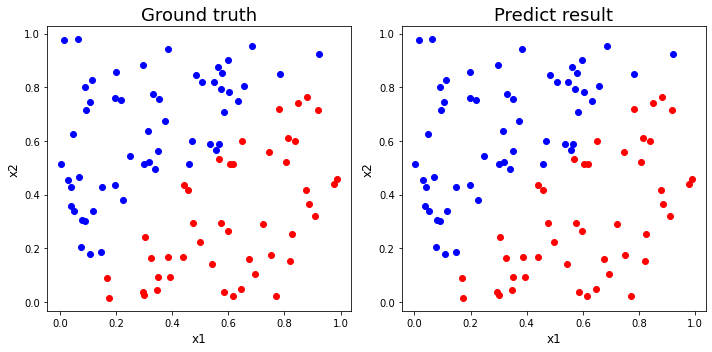

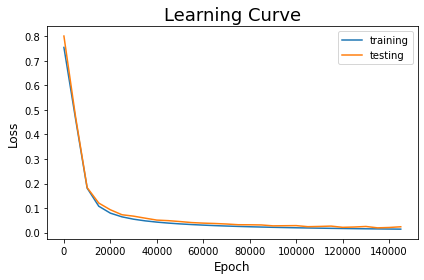

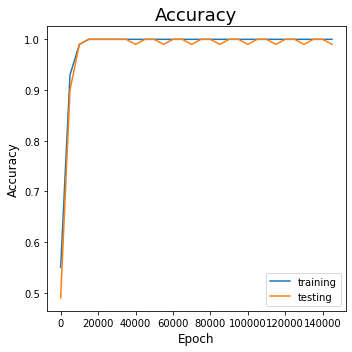

In [17]:
iter = 150000
seed = 10
x_train_linear, y_train_linear = generate_linear(100, seed)
parameters_linear, costs_linear, accs_linear, test_costs_linear, test_accs_linear = model(x_train_linear, y_train_linear, 10, 10, iter=iter, lr=0.01, linear=True)
*_, y_pred_linear = forward(x_train_linear, parameters_linear)
# print(y_pred_linear)
show_result(x_train_linear, y_train_linear, y_pred_linear)
plot_loss(iter, 5000, costs_linear, test_costs_linear)
plot_acc(iter, 5000, accs_linear, test_accs_linear)

epoch 0 training loss : 0.708420650942142 acc : 0.5238095238095238, testing loss : 0.7930513388822867 acc : 0.504950495049505
epoch 5000 training loss : 0.6888162244024808 acc : 0.5238095238095238, testing loss : 0.6949010660132924 acc : 0.504950495049505
epoch 10000 training loss : 0.6824536103976254 acc : 0.5238095238095238, testing loss : 0.6192080395547548 acc : 0.8910891089108911
epoch 15000 training loss : 0.6709867740563754 acc : 0.6666666666666666, testing loss : 0.5279434121756095 acc : 0.9306930693069307
epoch 20000 training loss : 0.6447028383113625 acc : 0.7142857142857143, testing loss : 0.42220238023263834 acc : 0.9405940594059405
epoch 25000 training loss : 0.5745787282040269 acc : 0.8571428571428571, testing loss : 0.3059302039547869 acc : 0.9702970297029703
epoch 30000 training loss : 0.42978326619745355 acc : 0.9047619047619048, testing loss : 0.1828695253617653 acc : 0.9801980198019802
epoch 35000 training loss : 0.28887751414319274 acc : 0.9047619047619048, testing 

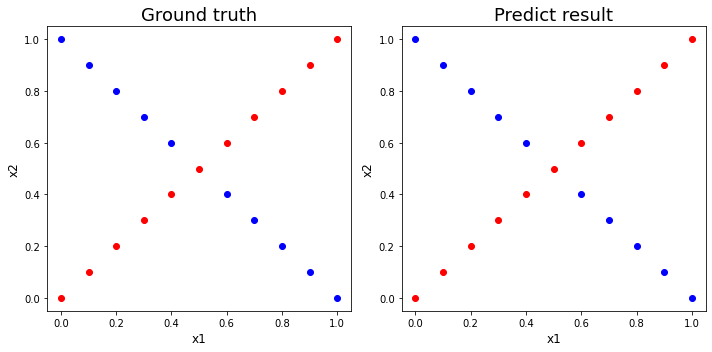

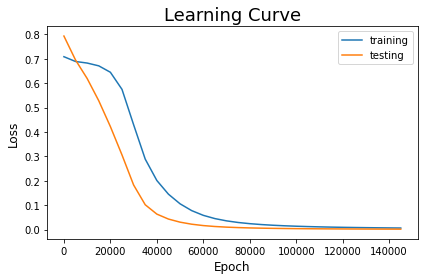

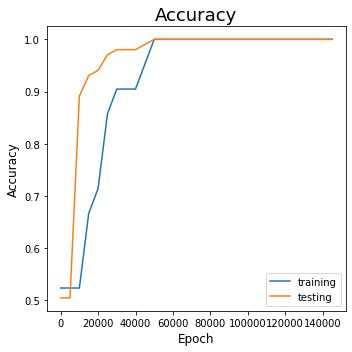

In [37]:
iter = 150000
seed = 10
x_train_xor, y_train_xor = generate_XOR_easy(10)
parameters_xor, costs_xor, accs_xor, test_costs_xor, test_accs_xor = model(x_train_xor, y_train_xor, 10, 10, iter=iter, lr=0.01, xor=True)
*_, y_pred_xor = forward(x_train_xor, parameters_xor)
# print(y_pred_linear)
show_result(x_train_xor, y_train_xor, y_pred_xor)
plot_loss(iter, 5000, costs_xor, test_costs_xor)
plot_acc(iter, 5000, accs_xor, test_accs_xor)

In [27]:
# linear test
seed = np.random.randint(low=0, high=10000, size=1)
x_test, y_test = generate_linear(1000, seed)
*_, y_pred = forward(x_test, parameters_linear)
print("acc:", accuracy(x_test, y_test, y_pred))
# show_result(x_test, y_test, y_pred)

acc: 0.986


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


acc: 1.0


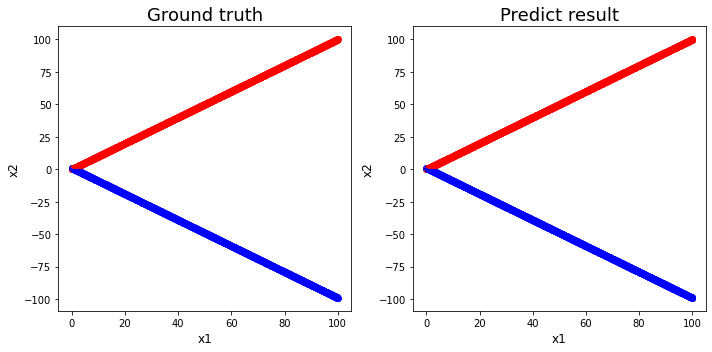

In [42]:
# xor test
x_test, y_test = generate_XOR_easy(100)
*_, y_pred = forward(x_test, parameters_xor)
print("acc:", accuracy(x_test, y_test, y_pred))
show_result(x_test, y_test, y_pred)